<a href="https://colab.research.google.com/github/szostaklab/aminoacylation/blob/main/gly_structure_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#IMPORTS
#Install+Import Packages
!pip install mechanize
import random
import re
import mechanize
import numpy as np
from random import *
import matplotlib.pyplot as plt
!pip install Bio
from Bio import SeqIO
from Bio.Seq import Seq
from collections import Counter 
from Bio.Cluster import kcluster
import statistics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import difflib
import seaborn as sns; sns.set_theme()
from collections import defaultdict
import collections
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
from collections import OrderedDict
import matplotlib.pyplot as plt
#!pip install ipython-autotime

In [14]:
#Upload Data and Define Parameters
aa_sequences = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1-1-gly_S3_L001_R1_001.fastq').readlines()
rna_only_sequences = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1-1-gly-NaOH_S4_L001_R1_001.fastq').readlines()

#Take the reverse complement? Enter 'yes' or 'no'
rc = 'no'

#Quality Cutoff - what fraction of positions should have <1% error probability?
quality_cutoff = 0.9

#Position motif1 starts at
motif_start = 1
#Motif1 define
motif = 'AAA'
#Position motif2 starts at
motif2_start = 23
#Motif2 define
motif2 = 'AAAAGATCGGAAGAGCACACGTCT'


In [15]:
def preprocess_seqs(list_of_seqs):
    
    quality = list_of_seqs[3::4]
    seqs = list_of_seqs[1::4]

    #Remove duplicates:
    unique_seqs = []
    unique_qualities = []
    indicies_of_unique_seqs = list(np.unique(seqs, return_index=True)[1])
    for index in sorted(np.unique(seqs, return_index = True)[1])[:-1]:
      unique_qualities.append(quality[index])
      unique_seqs.append(seqs[index])

    #Take RC if desired
    pre_trim = []
    if rc == 'yes':
      rc_seqs = []
      for sequence in unique_seqs:
          rc_seqs.append(str(Seq(sequence).reverse_complement()).strip('\n'))
      pre_trim = rc_seqs
    else:
      for sequence in unique_seqs:
          pre_trim.append(str(Seq(sequence)).strip('\n'))
    if rc == 'yes':
      print('Number of unique seqs after rc: '+str(len(pre_trim))) 

    #Trim
    trimmed = []
    for seq in pre_trim:
      trimmed.append(seq[(motif_start-1)+len(motif):(motif2_start-1)])

    print('Number of unique seqs after trimming: '+str(len(trimmed))) 

    #Counts of all seqs
    seq_dict = Counter(trimmed)
    seq_dict_list = [(k, v) for k, v in seq_dict.items()]
    sorted_seq_dict = sorted(seq_dict_list, key = lambda x: x[1], reverse=True)
    sorted_seq_dict_inve = sorted(seq_dict_list, key = lambda x: x[1])

    #Filter by quality
    high_quality = []
    acceptable_quals_1_percent_error = [5,6,7,8,9,':',';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
    for seq in range(len(unique_qualities)):
      overlap=0
      for char in list(set(unique_qualities[seq]).intersection(acceptable_quals_1_percent_error)):
            overlap+=unique_qualities[seq].count(char)
      if overlap/len(unique_qualities[1])>quality_cutoff:
            high_quality.append(trimmed[seq].strip("\n"))
    print('Number of high quality seqs: '+str(len(high_quality))) 
    return sorted_seq_dict, high_quality, seqs


#TOP SEQUENCES (ensure high quality)
def top_seqs(sorted_seq_dict, high_quality, seqs):
    num_seqs_to_analyze = 100
    #Top Sequences 
    print('Most Abundant Sequences, Counts')
    top_seqs = []

    for seq in sorted_seq_dict[:num_seqs_to_analyze]:
      for high_qual in high_quality:
        if high_qual in seq[0]:
          top_seqs.append(high_qual[motif_start+2:motif2_start-1])
          break

    #Print top 10 sequences
    for top in top_seqs[:10]:
      counts=0
      for seq in seqs:
        if top in seq:
          counts+=1
      print(top, counts)

    #Create file for R-Scape Covariation

    f = open("/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/gly_rscape"+str(num_seqs_to_analyze)+".txt", "w")
    f.write('# STOCKHOLM 1.0\n')
    f.write('\n')
    counter = 0
    for seq in top_seqs:
      counter+=1
      f.write(str(counter)+'\t'+seq+'\n')
    f.write('#=GC SS_cons	(((((((((,)))))))))\n')
    f.write('//')

In [16]:
#AA CONTROL
#STATISTICS (note: this takes a few mins per round)
print('Number of seqs in AA: '+str(round(len(aa_sequences)/4)))
aa_correct_seqs = []
for seq in range(len(aa_sequences)):
  if (seq-1)%4==0:
      if aa_sequences[seq][motif_start-1:(motif_start-1)+len(motif)] == motif and aa_sequences[seq][motif2_start-1:(motif2_start-1)+len(motif2)] == motif2:
        aa_correct_seqs+=(aa_sequences[seq-1:seq+3])
print('Number of seqs with correct constant region: '+str(len(aa_correct_seqs[1::4])))


aa_ctrl_sorted_seq_dict, aa_ctrl_high_quality, aa_ctrl_seqs = preprocess_seqs(aa_correct_seqs)
top_seqs(aa_ctrl_sorted_seq_dict, aa_ctrl_high_quality, aa_ctrl_seqs)


Number of seqs in AA: 2818273
Number of seqs with correct constant region: 2073979
Number of unique seqs after trimming: 1620022
Number of high quality seqs: 1574655
Most Abundant Sequences, Counts
GTCTTGTAGAGAGGGC 64
GGAGCGTAAGTGAGGC 60
GTCGTGTAGTGATGGC 43
AGTCGTAGGGATTGGC 34
GTTGTGGAGGGACGGC 26
GGATGAGGGGTTCGGC 28
GTCAGGGTCTGATGGC 43
TGGTGTTGGACTGGGC 30
GGACTTGAGGTTTGGC 16
GTCGTGGAGGGGCGGC 38


In [17]:
#RNA CONTROL
#STATISTICS (note: this takes a few mins per round)
print('Number of seqs in RNA: '+str(round(len(rna_only_sequences)/4)))
rna_correct_seqs = []
for seq in range(len(rna_only_sequences)):
  if (seq-1)%4==0:
      if rna_only_sequences[seq][motif_start-1:(motif_start-1)+len(motif)] == motif and rna_only_sequences[seq][motif2_start-1:(motif2_start-1)+len(motif2)] == motif2:
        rna_correct_seqs+=(rna_only_sequences[seq-1:seq+3])
print('Number of seqs with correct constant region: '+str(len(rna_correct_seqs[1::4])))


rna_ctrl_sorted_seq_dict, rna_ctrl_high_quality, rna_ctrl_seqs = preprocess_seqs(rna_correct_seqs)
top_seqs(rna_ctrl_sorted_seq_dict, rna_ctrl_high_quality, rna_ctrl_seqs)


Number of seqs in RNA: 681129
Number of seqs with correct constant region: 441026
Number of unique seqs after trimming: 415658
Number of high quality seqs: 405121
Most Abundant Sequences, Counts
GTTGTTTATCGATGGC 5
GTGGGTCCCGTGCGGC 10
ATGGGTCCCGAGTGGC 18
GTGATGCGTGGACGGC 4
GTGTCTTCCGGTCGGC 3
GGATTGCGAGGACGGC 8
ATTGAGGACGTGGGGC 5
TGTCTTGATGATAGGC 4
TCGGGCCACGAGGGGC 13
GTGCGCAGCTAGGGGC 3


In [18]:
#AA NOT RNA 
#STATISTICS (note: this takes a few mins per round)

aa_not_rna_high_quality = list(set(aa_ctrl_high_quality) - set(rna_ctrl_high_quality))

print('Number of seqs in AA but not RNA: '+str(round(len(aa_not_rna_high_quality))))

top_seqs(aa_ctrl_sorted_seq_dict, aa_not_rna_high_quality, aa_ctrl_seqs)


Number of seqs in AA but not RNA: 1470310
Most Abundant Sequences, Counts
GTCTTGTAGAGAGGGC 64
GGAGCGTAAGTGAGGC 60
AGTCGTAGGGATTGGC 34
GTTGTGGAGGGACGGC 26
GTCAGGGTCTGATGGC 43
TGGTGTTGGACTGGGC 30
GGACTTGAGGTTTGGC 16
GTCGTGGAGGGATGGC 39
GGTTGTGGGAACTGGC 33
GGTTGTTAGGACTGGC 17


In [66]:
def make_heatmap_bp(position_lhs):
    print(str(position_lhs+1)+'/'+ str(len(aa_not_rna_high_quality[0])-position_lhs))
    bps = []
    for seq in range(len(aa_not_rna_high_quality)):
        bps.append([aa_not_rna_high_quality[seq][position_lhs], aa_not_rna_high_quality[seq][len(aa_not_rna_high_quality[seq])-position_lhs-1]])
    bp_options = [['A', 'A'],['A', 'C'],['A', 'G'],['A', 'T'],['C', 'A'],['C', 'C'],['C', 'G'],['C', 'T'],['G', 'A'],['G', 'C'],['G', 'G'],['G', 'T'],['T', 'A'],['T', 'C'],['T', 'G'],['T', 'T']]
    option_counts = []
    for option in bp_options:
        option_counts.append(bps.count(option))
    
    xticks = ['A','C','G','T']
    yticks = ['A','C','G','T']
    sns.heatmap(np.array(option_counts).reshape(4,4), cmap='coolwarm', xticklabels=xticks, yticklabels=yticks)
    print(option_counts)
    plt.title(str(position_lhs+1)+'/'+ str(len(aa_not_rna_high_quality[0])-position_lhs))
    plt.show()



1/19
[7, 3938, 3, 1, 4, 1773, 0, 1, 1082, 1461021, 172, 953, 0, 1352, 1, 2]


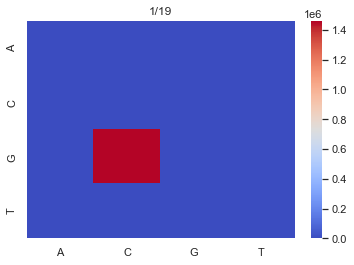

2/18
[1, 1, 1185, 0, 2155, 621, 1462043, 606, 3, 1, 1589, 1, 4, 2, 2097, 1]


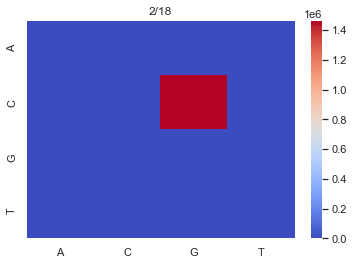

3/17
[0, 0, 1007, 0, 1577, 404, 1464536, 860, 0, 1, 282, 0, 3, 0, 1637, 3]


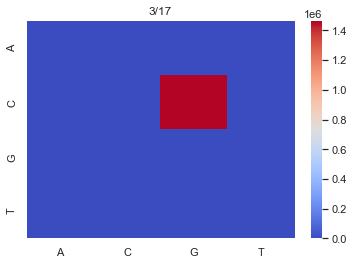

4/16
[40656, 22981, 78346, 136036, 26708, 15654, 103586, 32265, 112146, 144599, 186110, 165649, 132797, 31345, 174029, 67403]


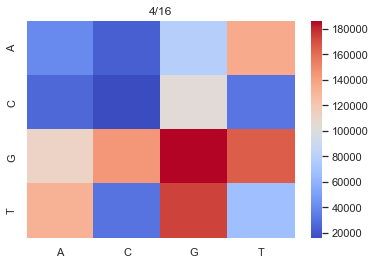

5/15
[46562, 26827, 88615, 123539, 31631, 19341, 118579, 39605, 113485, 120799, 153076, 155208, 145256, 38397, 172386, 77004]


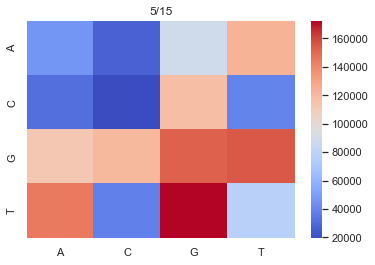

6/14
[57480, 34972, 116883, 126233, 36284, 25779, 113541, 48373, 103681, 97035, 155476, 136396, 130042, 45059, 156873, 86203]


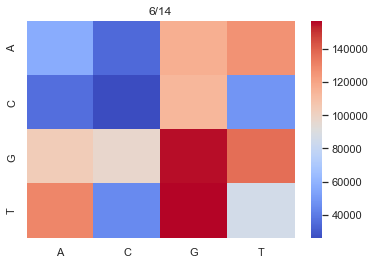

7/13
[69786, 33946, 108227, 107312, 48637, 25876, 121522, 53391, 116047, 80057, 161676, 126174, 127847, 42569, 156393, 90850]


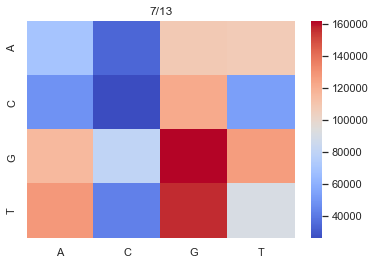

8/12
[49887, 66006, 92664, 67986, 37788, 52614, 96583, 46208, 94755, 167715, 161114, 128207, 83606, 95802, 139658, 89717]


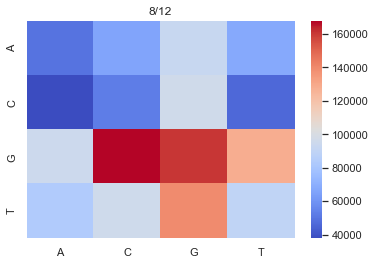

In [67]:
for i in range(8):
    make_heatmap_bp(i)
